In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Getting Data

To fit a model, we need at least one series. I think there's a misconception that we need **every** series -- this is NOT true. An advantage of this method is that we can be missing datapoints or entire series and it's still OK.

There are lots of places to get data. FRED, World Bank, OECD, and Eurostat are good places to get started, but I strongly recommend you take data directly from statistical office of the country you are working with if possible. 

Generally, you want QUARTERLY data, **seaonally adjusted** if possible. If it's not seasonally adjusted, you will have to do this yourself. 

Using CONSTANT prices is good, but pay attention to how the prices are adjusted. You should not use a series adjusted with CHAINED PRICES.

# Example 1: GDP Data

We want quarterly, seasonally adjusted GDP at constant prices. For the United States, I can get this from FRED as series NAEXKP01USQ652S. I can use FRED datareader to get this, but let's say that I've just downloaded it from the web and I want to load it. I can do this with `pd.read_csv`.

In [2]:
from pandas_datareader.fred import FredReader
# data = FredReader(symbols=['NAEXKP01USQ652S'], start='1900', end=None).read()
# data.to_csv('usa_gdp_seasonally_adjusted.csv')

df = pd.read_csv('usa_gdp_seasonally_adjusted.csv')

I use `df.head()` to look at the first 5 rows of data, bascially have a peek at what I'm dealing with. When I load the data it has two columns: date and GDP.

In [3]:
df.head()

,DATE,NAEXKP01USQ652S
0,1960-01-01,3.277847e+12
1,1960-04-01,3.260177e+12
2,1960-07-01,3.276133e+12
3,1960-10-01,3.234087e+12
4,1961-01-01,3.255914e+12


The name of the GDP column is hideous, so I change it by passing a new list of column names

In [4]:
df.columns = ['Date', 'Y']

In [5]:
df.head()

,Date,Y
0,1960-01-01,3.277847e+12
1,1960-04-01,3.260177e+12
2,1960-07-01,3.276133e+12
3,1960-10-01,3.234087e+12
4,1961-01-01,3.255914e+12


Next, always check the datatypes you have. Something might look like a number (`int` or `float`), but it's a string for some reason. Use `df.info()` to have a look. "Object" means a string. You can see that Date is an object -- that's bad -- but GDP is a float64 -- that's good!

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    251 non-null    object 
 1   Y       251 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


We can change the date from a string to a `DateTime` by using `pd.to_datetime`. This function is quite smart, so if you have dates in a "normal" format like YYYY-MM-DD or DD-MM-YYYY, it can figure it out. For trickier data, [check the docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html).

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

Calling `df.info()` again, we see that `Date` is now a `datetime64` object. This is what we want, because it gives us access to a lot of nice things. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    251 non-null    datetime64[ns]
 1   Y       251 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


Next, we want to set the date as the index. To do this, use `df.set_index()`.

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df.head()

,Y
Date,
1960-01-01,3.277847e+12
1960-04-01,3.260177e+12
1960-07-01,3.276133e+12
1960-10-01,3.234087e+12
1961-01-01,3.255914e+12


<AxesSubplot: xlabel='Date'>

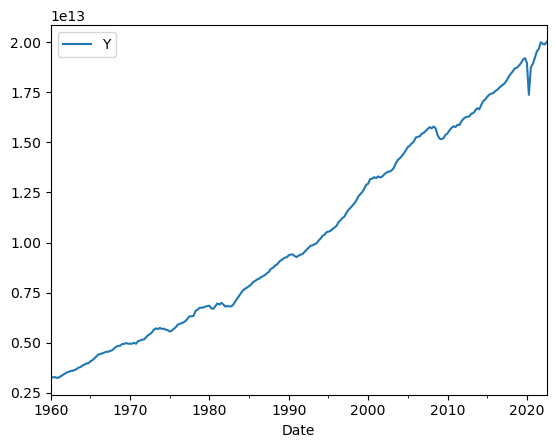

In [11]:
df.plot()

## Detrending Step 1: Take Logs

This data is obviously not stationary, so we need to process it. Start by taking logs. I will show two ways to do this, and you can pick the one you like the best.

### Method 1: Direct

You can just pass the column `df.Y` to `np.log`

<AxesSubplot: xlabel='Date'>

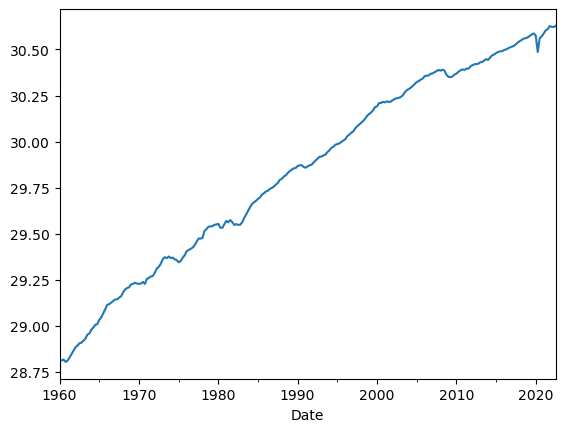

In [12]:
df['logY'] = np.log(df.Y)
df.logY.plot()

## Method 2: Using df.apply

You can use `df.apply` to apply a function to all columns at the same time.

In [13]:
df['logY2'] = df.Y.apply(np.log)

This next cell just checks that the two methods are the same

In [14]:
(df.logY == df.logY2).all()

True

### Aside: Why Logs?

We take logs to get percent change from the steady state. What is the connection between logs and percent change?

Begin with the formula for percent change:

$$\text{% Change} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}}$$

We can split up the numerator on the right side into two fractions and write this as:

$$\text{% Change} = \frac{\text{New Value}}{\text{Old Value}} - 1$$

Now take the -1 to the left

$$1 + \text{% Change} = \frac{\text{New Value}}{\text{Old Value}}$$

Take logs of both sides:

$$\log \left ( 1 + \text{% Change} \right ) = \log \left ( \frac{\text{New Value}}{\text{Old Value}} \right )$$

Recall that $\log\frac{x}{y} = \log x - \log y$, so finally we have:

$$\log \left ( 1 + \text{% Change} \right ) = \log \text{New Value} - \log \text{Old Value}$$

The last thing we need to know to complete this aside is that $\log (1 + x) \approx x$ if $x \approx 0$. To show this, I plot $\log 1 + x$ and $x$ below, for values for x between -0.1 and 0.1. You can see the approximation is really good between about -0.05 and 0.05

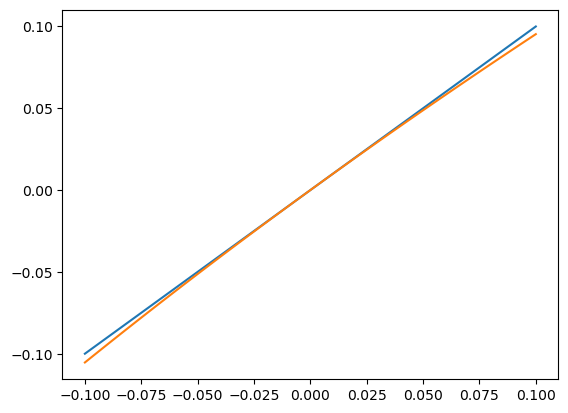

In [81]:
x_values = np.linspace(-0.1, 0.1)
fig, ax= plt.subplots()
ax.plot(x_values, x_values)
ax.plot(x_values, np.log(1 + x_values))

So if the percent change is small, between -5% and 5%, then we have:

$$\text{% Change} = \log \text{New Value} - \log \text{Old Value}$$

Or, adapting this to the RBC model:

$$\text{% Deviation from SS} = \log \text{Value} - \log \text{SS Value}$$

If we take the "SS Value" to be the trend, and we subtract the log trend from the log data, then we see that the result is a percent deviation from the trend.

Lastly, since macroeconomic series tend to move quite slowly, most of the time we'll find out data is within the -5% +5% window to make this a good approximation.

We could also directly compute the percent change, of course. The problem is that it's not very convenient mathematical function to work with. We want to take logs of our model anyway to make it linear, so it's nice that we can also log our data and get a really intuitive interpertation to boot.

# Detrending Step 2: Remove the trend

Now there are many choices to remove the trend. I will review the HP filter, and also show how to use OLS.

## Choice 1: OLS

First OLS. We need to make a design matrix. We will definitely need to have a constant, which is a column of all ones. To get this, we use `np.ones`.

In [15]:
constant = np.ones(df.shape[0])
constant

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Next, for the time trend, we just need to count from 0 to T. We can use `np.arange` to do this.

In [16]:
trend = np.arange(df.shape[0])
trend

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

To stick two vectors together as columns, we can use `np.c_`. This is a bit of a weird function. Unlike anything else in Python, it uses square brackets.

In [17]:
X = np.c_[constant, trend]
X[:5]

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

A common mistake will be to use it like this. This makes an error.

In [18]:
np.c_(constant, trend)

TypeError: 'CClass' object is not callable

If you're curious, `np.c_` is a special class that gives fast access to `np.hstack`, which is a regular function that works as you expect. The only difference is you need to pass **column vectors** to `np.hstack` to get the desired output, so we have to reshape constant and trend first. Putting `-1` in reshape means "whatever size it needs to be to make the other dimensions work". So we want 1 column, and however many rows that works out to.

As you can see, using `np.c_` is a lot shorter and easy to read.

In [21]:
np.hstack([constant.reshape(-1, 1), trend.reshape(-1, 1)])[:5]

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

To actually run the regression, use statsmodels. The way this is generally done is to make a model object, called `mod`, then call `mod.fit()` to make a Results object, and save it as `res`. You can do as you like, of course.

In [25]:
# Make X into a DataFrame so that the columns have nice names in the regression output
X = pd.DataFrame(X, index=df.index, columns=['Constant', 'Trend'])

In [26]:
import statsmodels.api as sm
mod = sm.OLS(df.logY, X, hasconst=True)
res = mod.fit()

To see the output table, use the `.summary()` method.

In [27]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.812e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          1.43e-234
Time:                        23:35:06   Log-Likelihood:                 343.71
No. Observations:                 251   AIC:                            -683.4
Df Residuals:                     249   BIC:                            -676.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      28.9384      0.008   3722.033      0.000      28.923      28.954
Trend          0.0072   5.38e-05    134.609      0.000       0.007       0.007
==============================================================================
Omnibus:                       17.543   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.802
Skew:                          -0.677   Prob(JB):                     5.01e-05
Kurtosis:                       2.752   Cond. No.                         288.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can plot the trend our regression predicted using the `.predict()` method.

<AxesSubplot: xlabel='Date'>

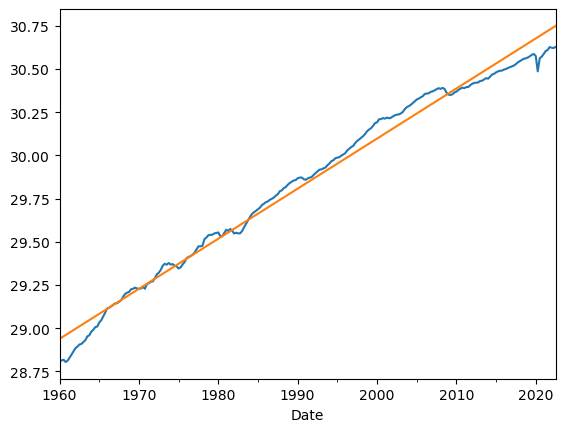

In [30]:
df.logY.plot()
res.predict(X).plot()

Recall from TD that we are running the following regression:

$$y_i = \alpha + \beta \cdot t + \epsilon_i$$

The straight line through our data is $\alpha + \beta \cdot t$, so the detrended data is $y_i - \alpha - \beta \cdot t = \epsilon_i$, i.e. the residuals. We can see the residuals using the `.resid` property.

<AxesSubplot: xlabel='Date'>

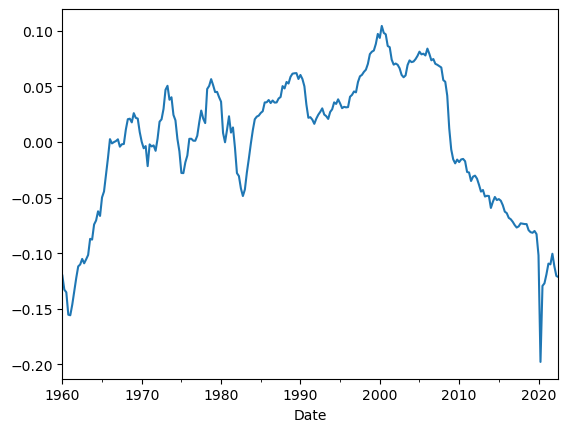

In [31]:
res.resid.plot()

Just like we saw in TD, the residuals are really big at the beginning and the end. Looking at the plot above, we can see that there is a bit of curvature in the log GDP series, like the rate of growth is slowing down over time. When you see curvature like this, it means the data has a non-zero second deivative. To give your prediction a non-zero second derivative, add a square trend

In [32]:
# Pow mean "power"
X['Trend^2'] = X.Trend.pow(2)

The quadratic term in significant, so that's good I guess. It's much more important to look at the plots.

In [33]:
quad_mod = sm.OLS(df.logY, X, hasconst=True)
quad_res = quad_mod.fit()
quad_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.216e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          2.99e-300
Time:                        23:38:07   Log-Likelihood:                 501.96
No. Observations:                 251   AIC:                            -997.9
Df Residuals:                     248   BIC:                            -987.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      28.8233      0.006   4656.488      0.000      28.811      28.836
Trend          0.0100      0.000     87.566      0.000       0.010       0.010
Trend^2    -1.109e-05   4.43e-07    -25.043      0.000    -1.2e-05   -1.02e-05
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.005
Skew:                          -0.001   Prob(JB):                        0.998
Kurtosis:                       2.979   Cond. No.                     8.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The quadratic trend fits really well!

<AxesSubplot: xlabel='Date'>

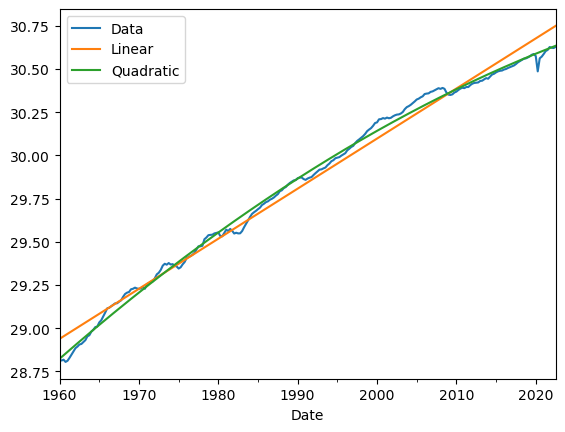

In [37]:
df.logY.plot(label='Data', legend=True)
# Choose only the columns that were in the first model!
res.predict(X[['Constant', 'Trend']]).plot(label='Linear', legend=True)
quad_res.predict(X).plot(label='Quadratic', legend=True)

The residuals look much nicer. The go up and down around zero, without staying up or down too long. We can see a business cycle of about 6 years, which is what theory tells us to expect. There are booms and recessions in the places where we expect booms and recessions. We can go with this.

<AxesSubplot: xlabel='Date'>

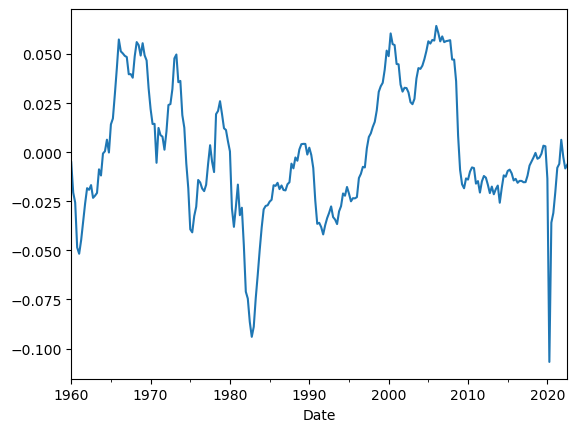

In [38]:
quad_res.resid.plot()

### An aside: You can add powers forever, but don't

Just to prove a point, you could add a cubed, squared, fourth power, etc.

In [39]:
for i in range(3, 6):
    X[f'Trend^{i}'] = X.Trend.pow(i)

Everything is significant.

In [40]:
poly_mod = sm.OLS(df.logY, X)
poly_res = poly_mod.fit()
poly_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.706e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:55:17   Log-Likelihood:                 596.56
No. Observations:                 251   AIC:                            -1181.
Df Residuals:                     245   BIC:                            -1160.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      28.7508      0.008   3455.304      0.000      28.734      28.767
Trend          0.0190      0.001     28.049      0.000       0.018       0.020
Trend^2       -0.0003   1.69e-05    -14.954      0.000      -0.000      -0.000
Trend^3     2.415e-06   1.71e-07     14.082      0.000    2.08e-06    2.75e-06
Trend^4    -1.013e-08   7.57e-10    -13.386      0.000   -1.16e-08   -8.64e-09
Trend^5     1.509e-11    1.2e-12     12.527      0.000    1.27e-11    1.75e-11
==============================================================================
Omnibus:                        2.810   Durbin-Watson:                   0.237
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.517
Skew:                          -0.236   Prob(JB):                        0.284
Kurtosis:                       3.132   Cond. No.                     1.73e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

You get a lot of local curvature. The trendline is now very steep before 1970, then flatter between 1970 and 2010, then flatter still. You could make an argument that these are reasonable breakpoints for the trend I suppose, with the oil shocks in the late 60s, then the global financial crisis in the early 2000s.

For models like this, there are two things you need to balance. Thing one is parsimony, which just means simplicity. The simplest model possible should be preferred, because every additional thing you add is one more assumption to justify. The quadratic curve fit really well, so we should prefer that.

The second thing is the economic story. The quadratic curve tells a story of gradual slowdown in growth. This 5th-order polynomial curve tells a story about regimes. The regimes occur at points that make economic sense, so that's good. But now someone can ask you "why 5 orders? why not 6 or 10 or 20?". 

Personally, I weight parsimony much higher than the story.

<AxesSubplot: xlabel='Date'>

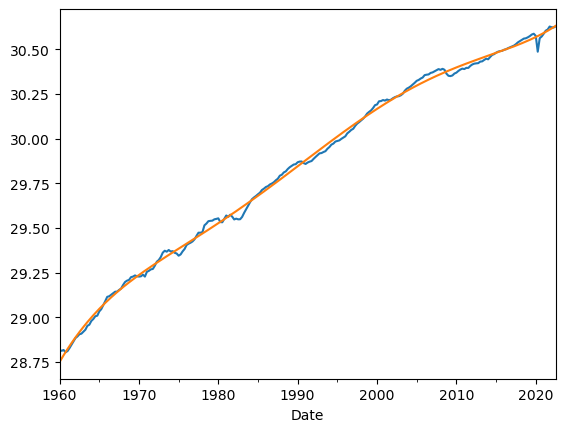

In [41]:
df.logY.plot()
poly_res.predict(X).plot()

## Option 2: HP Filter

A 2nd option for removing the trend is the HP filter. To use this, just call `sm.tsa.hp_filter.hpfilter` on your data. It returns two pandas `Series` objects: `cycle` and `trend`, in that order.

The filter works so that cycle + trend = data. Since we don't want the trend, the data we will show to the DSGE model is the cycle part.

In [44]:
cycle, trend = sm.tsa.hp_filter.hpfilter(df.logY)

Interestingly, the result of the HP filter looks a bit like the higher order polynomial regression.

<AxesSubplot: xlabel='Date'>

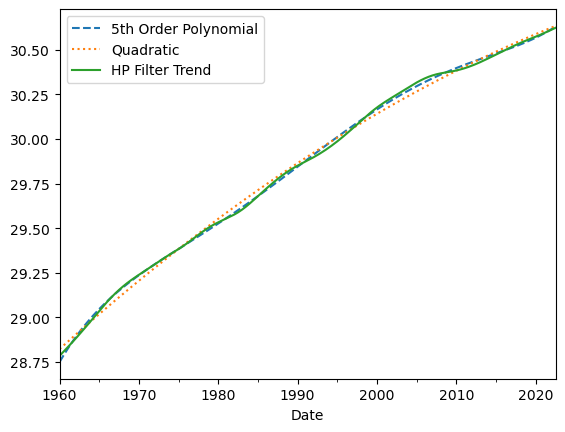

In [54]:
poly_res.predict(X).plot(label='5th Order Polynomial', legend=True, ls='--')
quad_res.predict(X[['Constant', 'Trend', 'Trend^2']]).plot(label='Quadratic', legend=True, ls='dotted')

trend.plot(label='HP Filter Trend', legend='True')

You can see that how much "local" fitting to the trend we do will have a big impact on how large the technology shocks are. Compare the size of the shocks in 1970 between the quadratic model and the HP Filter. If we go with the filter, the shock is 2.5%. If we go with the quadratic, it's 5%!

The difference is that the trend line is fit tighter to the data. The quadratic trend allows a lot of variation around the trend, and that variation needs to be all attributed to technology. The HP filter (and the 5th order polynomial), on the other hand, allow the trend to "wiggle" through the data. The result of that wiggling is to soak up some of the variation in the data, putting it into the trend rather than the DSGE dynamics.

All this is to say that, although this trend business seems needlessly complex, it actually is going to determine the output of our DSGE estimation!

<AxesSubplot: xlabel='Date'>

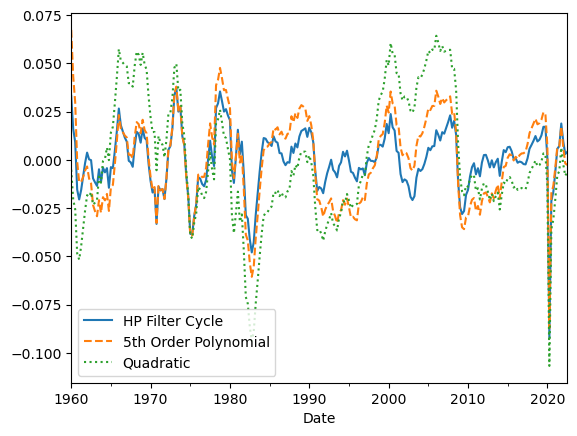

In [55]:
cycle.plot(label='HP Filter Cycle', legend=True)
poly_res.resid.plot(label='5th Order Polynomial', legend=True, ls='--')
quad_res.resid.plot(label='Quadratic', legend=True, ls='dotted')

## Which one should you use?

There's no clear winner. HP Filter was super popular for a long time, but it has come under fire recently because it induces data leakage. The filter is fits using the whole data series, so the trend value for each quarter includes information about the future. This could end up biasing the DSGE outputs.

On the other hand, OLS also looks at the whole dataset to estimate the betas, so it has the same problem. For a parimonious model, like linear or quadratic, however, this problem isn't so bad.

Here's the summary of your choices:


1. HP Filter is really easy to run, just one line of code. It also has a long history of being used for DSGE. But as a minus, it's under attack now.

2. A parsimonious OLS is easy to run too, but the trends can be too simple. It also has some data leakage problems, but not so much. You can make it more complex, but it just becomes more like the HP filter so why not just use that?

There are lots of other options of course. For this project, just choose one of these two.


# Example 2: Interest Rates

Let's look at a different kind of data, interest rates. Unlike GDP, these are already in percent, and they are already statonary (for the US, anyway). So the preprocessing will be a bit different.

In [69]:
# The symbol for the federal funds rate, FF, is nice and easy to remember.
# df = FredReader('FF', start='1900', end='2022').read()
# df.to_csv('fedfunds.csv')

Let's load the data from disk as if you downloaded it from the website first, without using the `FredReader`.

Instead of loading first then setting the dates like we did above, we can use a couple arguments in `pd.read_csv` to have that all taken care of for us. They are:

1. `parse_dates` can take a list of columns that we want to turn into `DateTime` objects.
2. `infer_datetime_format` takes a boolian (True or False) that tells pandas to guess the format of the dates. It's quite smart, so this will usually work fine.
3. `index_col` takes a list of columns to promote to the index right away.

We can put these together to 1. Load the data, 2. Change the `DATE` column type to `DateTime`, then 3. Make `DATE` the index.

In [104]:
df = pd.read_csv('fedfunds.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col=['DATE'])
df.head()

,FF
DATE,
1954-07-07,1.00
1954-07-14,1.22
1954-07-21,0.57
1954-07-28,0.63
1954-08-04,0.27


We expect the info to be a `float64` for `FF`, and `DatetimeIndex` for the index.

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 1954-07-07 to 2021-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FF      3522 non-null   float64
dtypes: float64(1)
memory usage: 55.0 KB


## Should we log the interest rate?

Recall that the whole point of logging was to get the data into percent deviations from the steady state. Interest rates are already percent changes, so we don't have to worry about this. 

If the data are stationary, it implies the steady state is a constant value. That means we just subtract the mean from the data, and we have the percent deviation from the steady state.

In [106]:
df.FF = df.FF - df.FF.mean()

## Aggregating High Frequency Data

You might have noticed that `FF` is not quarterly, it's weekly. We can aggregate high frequency data to a lower frequency using `df.resample()`. You tell the frequency you want by passing a string argument. The string code for quarterly is `QS`.

In [107]:
df.resample('QS')

This gives back a `DatetimeIndexResampler` object, which is a thing ready to do it's job. We just have to call an aggregation function. Options are:

1. `.sum()`. Add up everything inside each quarter to make quarterly data. This is appropriate for **FLOW** data.
2. `.last()`. Take only the last value and make it the quaterly value. That is, if we have 4 values (1, 2, 3, 4), we just use the 4. This is appropriate for **STOCK** data.
3. `.first()`. Take only the first value and make it the quarterly value. In the above example we use 1. Probably won't use this one much in time series.
3. `.mean()`. Take the mean of everything inside each quarter and use it as the quarterly value. This can be appropriate for **PRICE** data. Technically prices are stocks, but you might want to capture something about the volatility inside each period, which `.last()` doesn't do.
4. `.std()` and `.var()` to get a variance measurement. Not useful here.


Let's take the mean over each quarter and use that.

In [108]:
df.resample('QS').mean().head()

,FF
DATE,
1954-07-01,-3.615887
1954-10-01,-3.656656
1955-01-01,-3.294348
1955-04-01,-3.141271
1955-07-01,-2.712041


In case you're curious, the "S" in "QS" means "start". If you just ask for Q, it gives back a series where each index is the last date of the quarter. QS gives back a series where each index is the first day of the quarter.

In [109]:
df.resample('Q').mean().head()

,FF
DATE,
1954-09-30,-3.615887
1954-12-31,-3.656656
1955-03-31,-3.294348
1955-06-30,-3.141271
1955-09-30,-2.712041


Anyway, let's save our work.

In [110]:
df = df.resample('QS').mean()

<AxesSubplot: xlabel='DATE'>

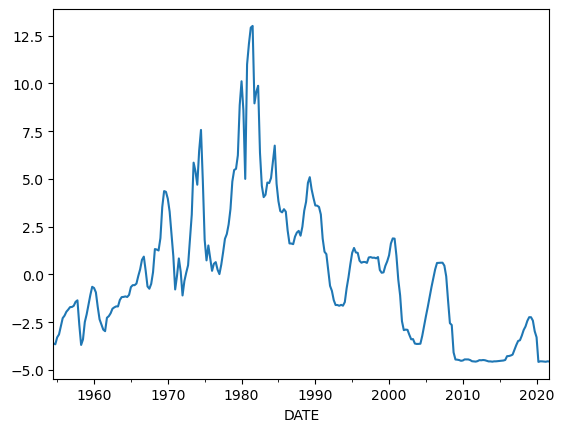

In [111]:
df.FF.plot()

## Annualized Data

The Federal Funds rate is reported as **annualized** rates of return. This means that each value gives the return on an investment held for one year at the current rate of interest. Interest compounds multiplicatively, so you take the 4th power:

$$r^{\text{annual}} = (1 + r)^4$$

We need to undo this, because the RBC model gives household interest on their capital each quarter. We could raise everything to the 1/4 power, but that can get messy. It's nicer to use another log approximation. Working from the fact that any small percentage is like a log, we can bring down the 1/4 on the power:

$$\log(1+a) \approx a = (1 + r)^{\frac{1}{4}} \approx \frac{1 + r}{4}$$

<AxesSubplot: xlabel='DATE'>

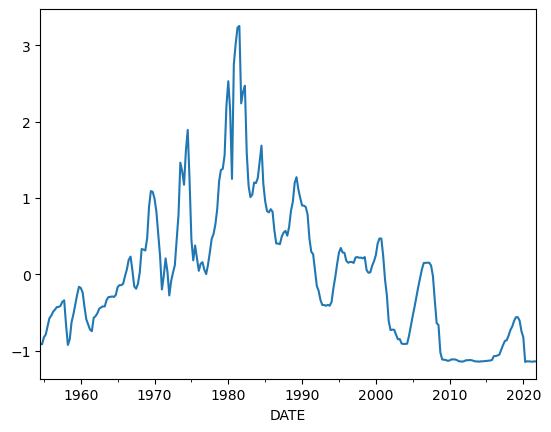

In [112]:
df.FF = df.FF.mul(0.25)
df.FF.plot()

### Percents vs Decimals

You can write "three percent" as either 3% or 0.03. It doesn't matter which one you choose, but you have to be consistent. 

Currently, FF is represented as 3%, while logY is represented as 0.03. This won't do. We either need to divide FF by 100 or multiply logY by 100. I choose the former. 

Remember which one you pick, because when you do impulse response functions it matters. If you pick 3%, giving a shock of 1 will be a 1% shock. If you pick 0.03, giving a shock of 1 will be a 100% shock. This is a huge difference!!

In [113]:
df.FF = df.FF.mul(1e-2)

<AxesSubplot: xlabel='DATE'>

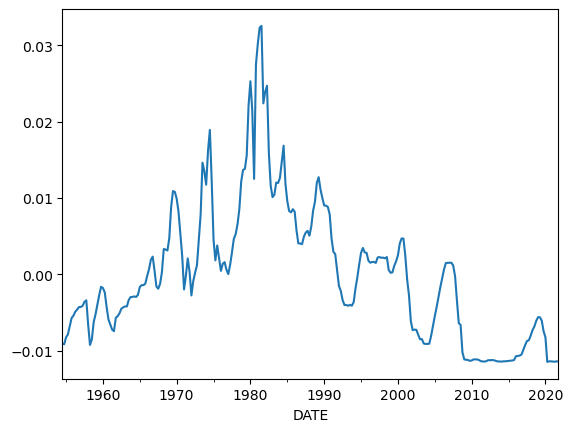

In [114]:
df.FF.plot()